In [ ]:
import pandas as pd
import numpy as np
import random
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/thesis/dataset/preprocessed_data.csv')
# actual dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/
data = data[data.columns[1:]]
data.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,1,140,289,0,0,172,1,0.0,0,0
1,49,1,2,160,180,0,0,156,1,1.0,2,1
2,37,0,1,130,283,0,2,98,1,0.0,0,0


In [ ]:
def setup(number_of_clusters, number_of_clients_in_each_cluster):
  list_data = data.values.tolist()
  total_clients = number_of_clusters * number_of_clients_in_each_cluster
  data_per_client = math.floor(len(list_data)/total_clients)
  curr_counter = 0
  cluster_client_data = []
  for i in range(number_of_clusters):
    cluster_data = []
    for j in range(number_of_clients_in_each_cluster):
      curr_client_data = []
      for k in range(data_per_client):
        curr_client_data.append(list_data[curr_counter])
        curr_counter = curr_counter+1
      cluster_data.append(curr_client_data)
    cluster_client_data.append(cluster_data)
  return cluster_client_data

In [ ]:
ultimate_data = setup(3, 2)

In [ ]:
def data_preperation_for_model_training(cluster_number, client_number_of_that_cluster):
  working_data = ultimate_data[cluster_number][client_number_of_that_cluster]
  X_list = []
  y_list = []
  for each_data in working_data:
    temp = []
    for i in range(11):
      temp.append(each_data[i])
    X_list.append(temp)
    y_list.append(each_data[11])

  X = np.asarray(X_list, dtype=np.float32)
  y = np.asarray(y_list, dtype=np.float32)
  return (X, y)

In [ ]:
def make_model():
  # Create a Sequential model
  model = Sequential()

  # Add a dense (fully connected) layer with 11 input units and 8 hidden units
  model.add(Dense(8, input_dim=11, activation='relu'))

  # Add a dense layer with 16 hidden units
  model.add(Dense(16, activation='relu'))

  # Add a dense layer with 32 hidden units
  model.add(Dense(32, activation='relu'))

  # Add a dense layer with 16 hidden units
  model.add(Dense(16, activation='relu'))

  # Add a dense layer with 8 hidden units
  model.add(Dense(8, activation='relu'))

  # Add another dense layer with 4 hidden units
  model.add(Dense(4, activation='relu'))

  # Add the output layer with 1 unit and a sigmoid activation function (for binary classification)
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
# global model (updated)
current_model = make_model()

In [ ]:
current_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 96        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 4)                 36        
                                                                 
 dense_6 (Dense)             (None, 1)                 5

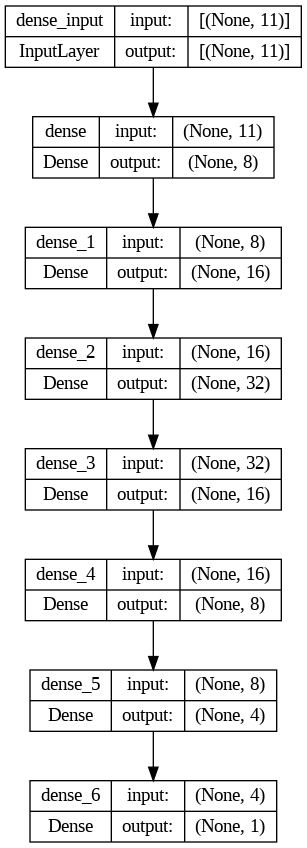

In [ ]:
# visualize the model
from tensorflow.keras.utils import plot_model
plot_model(current_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def accuracy_loss_graph_plotting(model, cluster_number, client_number):

  # summarize history for accuracy
  plt.plot(model.history.history['accuracy'])
  plt.title(f'cluster: {cluster_number} :: client {client_number} :: model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(model.history.history['loss'])
  plt.title(f'cluster: {cluster_number} :: client {client_number} :: model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train'], loc='upper left')
  plt.show()

In [ ]:
from tensorflow.keras.optimizers import SGD
def latest_model_training(cluster_number, client_number, X, y, latest_model, epochs, batch_size):
  # Compile the model
  sgd = SGD(learning_rate=0.1, momentum=0.9)
  latest_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

  # Train the model on your data
  latest_model.fit(X, y, epochs=epochs, batch_size=batch_size)

  # graph plotting
  accuracy_loss_graph_plotting(latest_model, cluster_number, client_number)

  # Evaluate the model
  loss, accuracy = latest_model.evaluate(X, y)
  print(f'Loss: {loss:.2f}, Accuracy: {accuracy*100:.2f}%')

  return latest_model

In [ ]:
def cluster_selection_algorithm(number_of_clusters, number_of_clusters_every_iteration):
  selected_clusters = []
  count = 0
  while(count<number_of_clusters_every_iteration):
    current_cluster_number = random.randint(0, number_of_clusters-1)
    if current_cluster_number not in selected_clusters:
      selected_clusters.append(current_cluster_number)
      count = count + 1
  return selected_clusters

In [ ]:
def model_aggregation(list_of_models):
  # implementing fedavg algorithm: https://www.codespeedy.com/get_weights-and-set_weights-functions-in-keras-layers/

  updated_model = list_of_models[0]

  # jot down all the weights and the biases of the model as the form of numpy array
  all_layers = []
  all_biases = []
  for curr_model in list_of_models:
    intermediate_layers = []
    intermediate_biases = []
    for layer in curr_model.layers:
      intermediate_layers.append(layer.get_weights()[0])
      intermediate_biases.append(layer.get_weights()[1])
    all_layers.append(intermediate_layers)
    all_biases.append(intermediate_biases)

  # avg the weights
  updated_layers = []
  for col in range(len(all_layers[0])):
    sum_layers = all_layers[0][col]
    for row in range(1, len(all_layers)):
      sum_layers = np.add(sum_layers, all_layers[row][col])
    avg_layer_weight = np.divide(sum_layers, len(all_layers))
    updated_layers.append(avg_layer_weight)

  # avg the biases
  updated_biases = []
  for col in range(len(all_biases[0])):
    sum_biases = all_biases[0][col]
    for row in range(1, len(all_biases)):
      sum_biases = np.add(sum_biases, all_biases[row][col])
    avg_biases_weight = np.divide(sum_biases, len(all_biases))
    updated_biases.append(avg_biases_weight)

  # usning set_weights() to update the weights
  count = 0
  for layer in updated_model.layers:
    layer.set_weights([updated_layers[count], updated_biases[count]])
    count = count + 1

  return updated_model

In [ ]:
def train_client(cluster_number, client_number, latest_model, epochs, batch_size):
  # prepare the data for this particular client
  (X, y) = data_preperation_for_model_training(cluster_number, client_number)

  # model training for this client
  updated_model = latest_model_training(cluster_number, client_number, X, y, latest_model, epochs, batch_size)

  #return the updated model
  return updated_model

In [ ]:
def CFL(iterations, epochs, batch_size, number_of_clusters, number_of_clients_in_each_cluster, number_of_clusters_every_iteration):
  if(number_of_clusters_every_iteration>number_of_clusters):
    raise Exception("Number of clusters in every iteration have to be less or equals to the total number of available clusters for the setup")

  for itr in range(iterations):
    global current_model

    # get the updated model
    latest_mdoel = current_model

    # select the cluster
    selected_clusters = cluster_selection_algorithm(number_of_clusters, number_of_clusters_every_iteration)

    cluster_level_aggregated_model = []


    for curr_cluster_number in selected_clusters:
      client_trained_model_for_single_cluster = []

      for curr_client_number in range(number_of_clients_in_each_cluster):
        updated_model = train_client(curr_cluster_number, curr_client_number, latest_mdoel, epochs, batch_size)
        client_trained_model_for_single_cluster.append(updated_model)

      # cluster level aggregation
      aggregated_model = model_aggregation(client_trained_model_for_single_cluster)

      cluster_level_aggregated_model.append(aggregated_model)

    global_aggregated_model = model_aggregation(cluster_level_aggregated_model)

    # update the current model
    current_model = global_aggregated_model

In [ ]:
CFL(10, 100, 10, 3, 2, 2)

In [ ]:
def test_the_gloabl_model():
  # prepare the whole dataset for the testing
  X_list = []
  y_list = []
  list_data = data.values.tolist()
  for each_data in list_data:
    temp = []
    for i in range(11):
      temp.append(each_data[i])
    X_list.append(temp)
    y_list.append(each_data[11])

  X = np.asarray(X_list, dtype=np.float32)
  y = np.asarray(y_list, dtype=np.float32)

  # test the latest model
  global current_model
  latest_model = current_model
  latest_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # confusion matrix creation
  y_pred = latest_model.predict(X)
  y_pred_ultimate = []
  for each_ele in y_pred:
    if(each_ele[0]>=0.5): y_pred_ultimate.append(1.0)
    else: y_pred_ultimate.append(0.0)
  y_pred_ultimate = np.array(y_pred_ultimate)
  cm = confusion_matrix(y, y_pred_ultimate)

  cm_df = pd.DataFrame(cm,
                     index = ['NORMAL','HEART DISEASE'],
                     columns = ['NORMAL','HEART DISEASE'])

  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()

  # Evaluate the model
  loss, accuracy = latest_model.evaluate(X, y)
  print(f'Loss: {loss:.2f}, Accuracy: {accuracy*100:.2f}%')

29/29 [==============================] - 0s 2ms/step


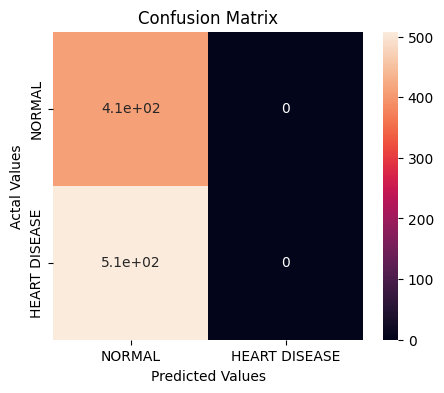

29/29 [==============================] - 0s 2ms/step - loss: 0.7721 - accuracy: 0.4466
Loss: 0.77, Accuracy: 44.66%


In [ ]:
test_the_gloabl_model()